<h1><b>1. Exploratory Data Analysis</b></h1>
<p>Let's first import the required libraries for this chapter.</p>

In [2]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

<p>We are going to use many datasets. Since we've already stored them in the same directory as our code, we can use the same path names.</p>

In [4]:
AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

<h2>1.1 Estimates of Location</h2>
<h3>Example - Location Estimates of Population and Murder Rates</h3>
<p><strong>Table 1-2.</strong> 2010 Census containing population and murder rates (units of murders per 100,000 people per year) for each state.

In [5]:
df_state = pd.read_csv(STATE_CSV)
print(df_state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


<p> Let's compute the mean.</p>

In [6]:
df_state['Population'].mean()

6162876.3

<p>To compute the trimmed mean we can use <code>trim_mean</code> from <code>scipy.stats</code>:</p>

In [7]:
print(trim_mean(df_state['Population'], 0.1))

4783697.125


<p>Ok! Now, how about computing the median?</p>

In [8]:
print(df_state['Population'].median())

4436369.5


<p>Since <code>trim_mean</code> with a 10% (0.1) drop, which consists of removing 5 states from each end of the dataset population-wise, excludes the extremes, we get a smaller value when comparing with the mean.</p>
<p>To compute the average murder rate for the country, we need to use a <strong>weighted average</strong> to take into account the different demographics of each state.</p>

In [9]:
print(df_state['Murder.Rate'].mean())

4.066


In [10]:
# Use weighted mean with np.average
print(np.average(df_state['Murder.Rate'], weights=df_state['Population']))

4.445833981123393


To get the <strong>weighted median</strong>, use the <code>wquantiles</code> package.</p>

In [11]:
print(wquantiles.median(df_state['Murder.Rate'], weights=df_state['Population']))

4.4


<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li>Although the mean is the basic metric for location, it can be sensitive to extreme values.</li>
<li>Other metrics such as the median and the trimmed mean are more robust since they are not as affected by outliers.</li>
</ul>
</p>
</div>

<hr>
<h2>1.2 Estimates of Variability</h2>
<h3>1.2.1 Standard Deviation and Related Estimates</h3>

In [27]:
print(df_state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


<p><i>Table 1-3. 2010 Census containing population and murder rates (units of murders per 100,000 people per year) for each state</i>.

<p>Let's calculate the standard deviation.</p>

In [16]:
print(df_state['Population'].mean())

6162876.3


In [13]:
print(df_state['Population'].std())

6848235.347401142


<p>Calculating the <strong>interquantile range</strong> - we must find the difference between the 75th and the 25th quantile.</p>

In [17]:
print(df_state['Population'].quantile(0.75) - df_state['Population'].quantile(0.25))

4847308.0


<p>When it comes to the <strong>median absolute deviation (MAD)</strong>, we can obtain it by using the function <code>robust.scale</code> from the <code>statsmodels</code> package.</p>

In [20]:
print(robust.scale.mad(df_state['Population']))
print(abs(df_state['Population'] - df_state['Population'].median()).median()/ 0.6744897501960817)

3849876.1459979336
3849876.1459979336


<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li><strong>Variance</strong> and <strong>standard deviation</strong> are very relevant as statistics of variability - both are <strong>very sensitive</strong> to extreme measures.</li>
<li>More robust metrics - Mean absolute deviation, MAD, and percentiles.</li>
</ul>
</p>
</div>

<hr>
<h2>1.3 Exploring the Data Distribution</h2>
<h3>1.3.1 Percentiles and Boxplots</h3>
<p>We can use the <code>pandas</code> <code>quantile</code> method to get the distribution of data in percentiles:</p>
<h4>Percentiles</h4>

In [23]:
# Percentiles
print(df_state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [24]:
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(df_state['Murder.Rate'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


<p><i>Table 1-4. Percentiles of murder rate by US state.</i></p>

<p>We can see that the murder rate in the US displays a high variability. The 5th percentile is only 1.6 murders / 100,000 people, while the .95 quantile is 0.6510.
<h4>Boxplots</h4>

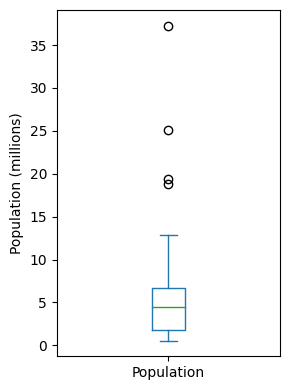

In [25]:
ax = (df_state['Population']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Population (millions)')

plt.tight_layout()
plt.show()

<p><i>Figure 1-2. Boxplot of state populations.</i></p>

<p><strong>Observations:</strong></p>
<ul>
<li>The median population is around 5 million.</li>
<li>Half the states fall between 2 and 7 million, approximately.</li>
<li>The top and the bottom are the 75th and the 25th percentiles.</li>
<li>The median is represented by the horizontal line in the box.</li>
<li>The lines, also called <i>whiskers</i>, extend from the top and bottom of the box to indicate the range for the bulk of the data.</li>
<li>Any data outside the wiskers is plotted as single circles and often represent <i>outliers</i>.</li>
</ul>

<h3>1.4.1 Frequency Tables and Histograms</h3>
<h4>Frequency Tables</h4>
<p>Use the <code>.cut()</code> function from <code>pandas</code> to create a series that maps the values into the segments. Coupled with <code>value_counts</code>, we can retrieve the frequency table:</p>


In [28]:
binned_population = pd.cut(df_state['Population'], 10)
print(binned_population.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


In [29]:
# Table 1.5
binned_population.name = 'binned_population'
df = pd.concat([df_state, binned_population], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binned_population'):
    groups.append({
        'bin_range': group,
        'count': len(subset),
        'states': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                  bin_range  count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              states  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

<p><i>Table 1-5. A frequency table of population by state.</i></p>

<p><strong>Observations:</strong></p>
<ul>
<li>Wyoming is the least populous state, with 526,935 people, while California is the most populous, with 37,253,956 inhabitants.</li>
<li>This gives us a range of 36,727,021, which, divided by the 10 bins, result in a value of 3,672,702.1.</li>
<li>Although the two bins below California are empty, it is important to include empty bins, as they provide useful information.</li>
</ul>
<h4>Histogram</h4>


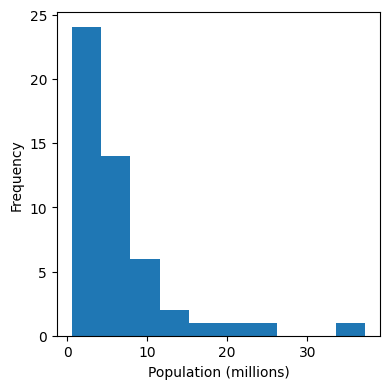

In [32]:
ax = (df_state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Population (millions)')

plt.tight_layout()
plt.show()

<p><i>Figure 1-3. Histogram of state populations.</i></p>